In [1]:
# force geopandas to use shapely instead of pygeos
import os
os.environ['USE_PYGEOS'] = '0'

import numpy as np
import pandas as pd
import plotly.express as px
from shapely import wkt
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
# datetime manipulation helper functions

def filter_by_date_range(df: pd.DataFrame, column_name: str, start_string: str, end_string: str):
    return df[(df[column_name] >= pd.Timestamp(start_string)) & (df[column_name] <= pd.Timestamp(end_string))]

In [3]:
meters = pd.read_csv("../data/Parking_Meters.csv")

In [4]:
meters['shape'] = meters['shape'].apply(wkt.loads)
meters = gpd.GeoDataFrame(meters, geometry='shape')
meters.crs = 'EPSG:4326'

street_df = pd.read_csv('../data/street_sweeping.csv')
street_df = street_df[~street_df.Line.isnull()]
street_df.loc[:, 'Line'] = street_df.Line.apply(wkt.loads)
street_df = gpd.GeoDataFrame(street_df, geometry='Line')
street_df.crs = 'EPSG:4326'

unique_streets = street_df.drop_duplicates(subset='Line')

In [5]:
# filter to only include active meters

active = meters[(meters["ACTIVE_METER_FLAG"] == "M") | (meters["ACTIVE_METER_FLAG"] == "T")]

In [6]:
active.shape

(29313, 45)

In [7]:
# joins active meters to street

joined = gpd.sjoin_nearest(active, unique_streets, distance_col='dist', how='left')
joined.shape

/Users/bryanwang/opt/miniconda3/envs/stat-222/lib/python3.9/site-packages/geopandas/array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


(29334, 63)

In [8]:
joined['street_id'] = joined['Corridor'] + ' ' + joined['Limits']

In [9]:
# how many meters on each street

joined['street_id'].value_counts()

Channel Start: 601-698 Block  -  End: 601-698 Block      172
Illinois St 16th St  -  Mariposa St                      167
Mission Bay Blvd North erry A Francois Blvd - Vara St    129
Bluxome St 04th St  -  05th St                           126
Main St Market St  -  Mission St                         110
                                                        ... 
Cleveland St Sherman St  -  07th St                        1
Vallejo St Battery St  -  Cowell Pl                        1
21st St Valencia St  -  Guerrero St                        1
Cortland Ave Mission St  -  Coleridge St                   1
Sansome St Merchant St  -  Washington St                   1
Name: street_id, Length: 2113, dtype: int64

In [10]:
joined[joined['street_id'] == 'The Embarcadero Washington St  -  Broadway']['POST_ID'].nunique()

34

In [11]:
# transaction data 54 seconds

pay = pd.read_parquet("../data/meter_data_2022.parquet")

In [12]:
pay.head()

TRANSMISSION_DATETIME    POST_ID           STREET_BLOCK  \
45536904  222408714_4_01012022002410  831-02200  EMBARCADERO SOUTH 200   
45536905  222408715_4_01012022003157  546-28060    LEAVENWORTH ST 2800   
45536906  222408723_4_01012022011253  830-03290  EMBARCADERO NORTH 300   
45536907  222408728_4_01012022020117  336-14220           BUSH ST 1400   
45536908  222408729_4_01012022022638  568-05550         MISSION ST 500   

         PAYMENT_TYPE        SESSION_START_DT          SESSION_END_DT  \
45536904         CASH  2022/01/01 12:24:10 AM  2022/01/01 12:24:10 AM   
45536905         CASH  2022/01/01 12:31:57 AM  2022/01/01 12:31:57 AM   
45536906         CASH  2022/01/01 01:12:53 AM  2022/01/01 01:12:53 AM   
45536907         CASH  2022/01/01 02:01:17 AM  2022/01/01 02:01:17 AM   
45536908         CASH  2022/01/01 02:26:38 AM  2022/01/01 02:26:38 AM   

         METER_EVENT_TYPE  GROSS_PAID_AMT  
45536904               NS            1.50  
45536905               NS            0.50  
45536906               NS            0.50  
45536907               NS            0.25  
45536908               NS            1.00

In [76]:
# 36 seconds

df = pd.merge(pay, joined, on='POST_ID')

In [77]:
df.head()

TRANSMISSION_DATETIME    POST_ID           STREET_BLOCK PAYMENT_TYPE  \
0  222408714_4_01012022002410  831-02200  EMBARCADERO SOUTH 200         CASH   
1  222412313_4_01022022121822  831-02200  EMBARCADERO SOUTH 200  CREDIT CARD   
2  222412993_4_01022022135210  831-02200  EMBARCADERO SOUTH 200  CREDIT CARD   
3  222448944_4_01032022140304  831-02200  EMBARCADERO SOUTH 200  CREDIT CARD   
4  832929888_9_01032022180700  831-02200  EMBARCADERO SOUTH 200  PAY BY CELL   

         SESSION_START_DT          SESSION_END_DT METER_EVENT_TYPE  \
0  2022/01/01 12:24:10 AM  2022/01/01 12:24:10 AM               NS   
1  2022/01/02 12:18:22 PM  2022/01/02 01:18:22 PM               NS   
2  2022/01/02 01:52:10 PM  2022/01/02 03:52:17 PM               NS   
3  2022/01/03 02:03:04 PM  2022/01/03 04:23:28 PM               NS   
4  2022/01/03 06:07:00 PM  2022/01/03 08:07:00 PM               NS   

   GROSS_PAID_AMT  OBJECTID  PARKING_SPACE_ID MS_PAY_STATION_ID  MS_SPACE_NUM  \
0            1.50   5272708                 0                 -             0   
1            8.00   5272708                 0                 -             0   
2           14.49   5272708                 0                 -             0   
3            9.06   5272708                 0                 -             0   
4            4.00   5272708                 0                 -             0   

  SENSOR_FLAG ON_OFFSTREET_TYPE  OSP_ID JURISDICTION  PM_DISTRICT_ID  \
0           Y                ON     0.0         PORT             1.0   
1           Y                ON     0.0         PORT             1.0   
2           Y                ON     0.0         PORT             1.0   
3           Y                ON     0.0         PORT             1.0   
4           Y                ON     0.0         PORT             1.0   

   BLOCKFACE_ID ACTIVE_METER_FLAG REASON_CODE SMART_METER_FLAG METER_TYPE  \
0        831021                 M           -                Y         SS   
1        831021                 M           -                Y         SS   
2        831021                 M           -                Y         SS   
3        831021                 M           -                Y         SS   
4        831021                 M           -                Y         SS   

  METER_VENDOR METER_MODEL CAP_COLOR PCO_BEAT OLD_RATE_AREA  STREET_ID  \
0          IPS          M5      Grey   PORT-2        Port 7      831.0   
1          IPS          M5      Grey   PORT-2        Port 7      831.0   
2          IPS          M5      Grey   PORT-2        Port 7      831.0   
3          IPS          M5      Grey   PORT-2        Port 7      831.0   
4          IPS          M5      Grey   PORT-2        Port 7      831.0   

         STREET_NAME  STREET_NUM  PARITY_DIGIT_POSITION  STREET_SEG_CTRLN_ID  \
0  EMBARCADERO SOUTH       220.0                    2.0           12551102.0   
1  EMBARCADERO SOUTH       220.0                    2.0           12551102.0   
2  EMBARCADERO SOUTH       220.0                    2.0           12551102.0   
3  EMBARCADERO SOUTH       220.0                    2.0           12551102.0   
4  EMBARCADERO SOUTH       220.0                    2.0           12551102.0   

   ORIENTATION  LONGITUDE   LATITUDE LEGISLATION_REF  LEGISLATION_DT  \
0        225.0 -122.39102  37.791609             NaN             NaN   
1        225.0 -122.39102  37.791609             NaN             NaN   
2        225.0 -122.39102  37.791609             NaN             NaN   
3        225.0 -122.39102  37.791609             NaN             NaN   
4        225.0 -122.39102  37.791609             NaN             NaN   

  WORK_ORDER COMMENTS COLLECTION_ROUTE COLLECTION_SUBROUTE PMR_ROUTE NFC_KEY  \
0        NaN      NaN              614               614-1    Port 2    71ME   
1        NaN      NaN              614               614-1    Port 2    71ME   
2        NaN      NaN              614               614-1    Port 2    71ME   
3        NaN      NaN              614      

In [78]:
cols_to_keep = ['POST_ID', 'SESSION_START_DT', 'SESSION_END_DT', 'street_id']
df = df[cols_to_keep]

In [79]:
df.street_id

0           The Embarcadero Folsom St  -  Howard St
1           The Embarcadero Folsom St  -  Howard St
2           The Embarcadero Folsom St  -  Howard St
3           The Embarcadero Folsom St  -  Howard St
4           The Embarcadero Folsom St  -  Howard St
                             ...                   
19093804           Geary Blvd 16th Ave  -  17th Ave
19093805           Geary Blvd 16th Ave  -  17th Ave
19093806           Geary Blvd 16th Ave  -  17th Ave
19093807           Geary Blvd 16th Ave  -  17th Ave
19093808            Gough St Linden St  -  Hayes St
Name: street_id, Length: 19093809, dtype: object

In [80]:
# for one area only

df = df[df.street_id.str.contains('Embarcadero')]
df.shape

(460251, 4)

In [81]:
# filter out prepaid meters
# 1 minute

df = df[df.SESSION_START_DT != df.SESSION_END_DT]

In [82]:
# change start and end times to datetime
# 92 minutes

df.SESSION_START_DT = pd.to_datetime(df.SESSION_START_DT)
df.SESSION_END_DT = pd.to_datetime(df.SESSION_END_DT)

In [83]:
dic = dict()
for column in df.columns:
    if column == 'SESSION_START_DT':
        dic[column] = "min"
    elif column == 'SESSION_END_DT':
        dic[column] = "max"
    else:
        dic[column] = "first"

In [84]:
# merge rows where meter transactions were within 3 mins

def merge_overlapping_rows(df):
    # initialize the group column
    df['group'] = 0
    df = df.sort_values("SESSION_START_DT").reset_index(drop = True)

    # initialize variables for the current group number and end time
    group_num = 0
    prev_end_time = df.loc[0, 'SESSION_END_DT']

    # loop over the rows and assign group numbers
    for i in range(1, len(df)):
        if df.loc[i, 'SESSION_START_DT'] >= (prev_end_time + pd.Timedelta(minutes=3)):
            # new interval, increment group number and update previous end time
            group_num += 1
            prev_end_time = df.loc[i, 'SESSION_END_DT']
            df.loc[i, 'group'] = group_num
        else:
            # overlapping interval, assign the same group number and update previous end time
            df.loc[i, 'group'] = group_num
            prev_end_time = max(prev_end_time, df.loc[i, 'SESSION_END_DT'])

    # group by the group column and aggregate the start and end times
    result = df.groupby('group').agg(dic).reset_index(drop=True)

    return result

In [85]:
# 34 mins

temp = df.groupby("POST_ID").apply(merge_overlapping_rows)

In [24]:
# sanity check

# one_date_temp = filter_by_date_range(temp, 'SESSION_START_DT', '1-02-2022', '1-03-2022')
# one_date_temp.shape

(77, 4)

In [25]:
# one_date = filter_by_date_range(df, 'SESSION_START_DT', '1-02-2022', '1-03-2022')

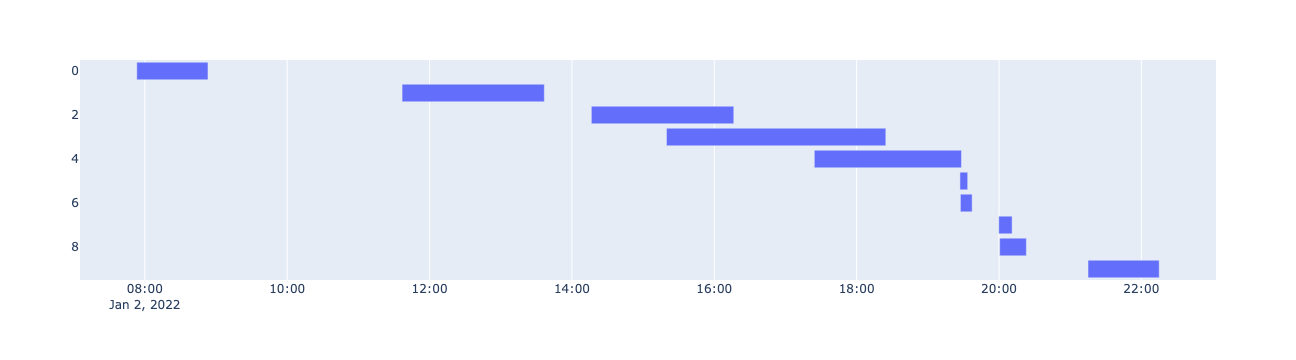

In [27]:
# fig = px.timeline(one_date[one_date.POST_ID == '830-04170'].sort_values('SESSION_START_DT'), x_start="SESSION_START_DT", x_end="SESSION_END_DT")
# fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
# fig.show()

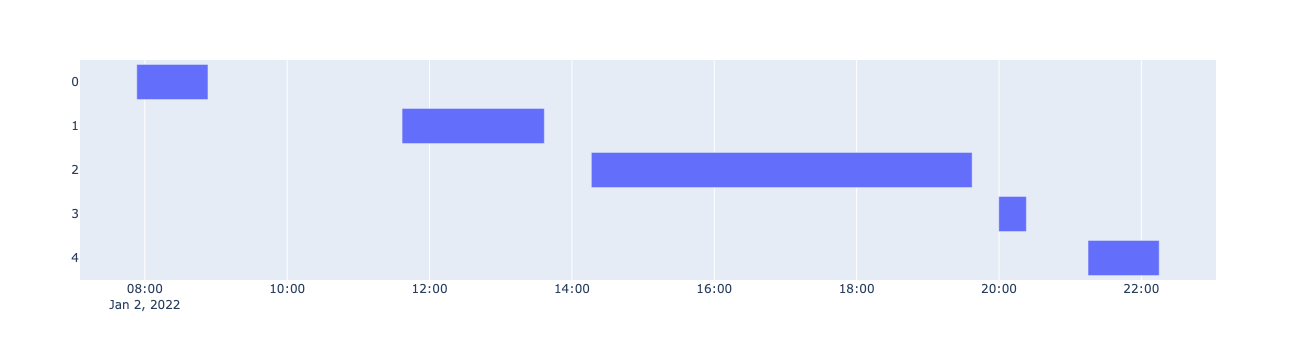

In [28]:
# fig = px.timeline(one_date_temp[one_date_temp.POST_ID == '830-04170'].sort_values('SESSION_START_DT'), x_start="SESSION_START_DT", x_end="SESSION_END_DT")
# fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
# fig.show()

In [86]:
# replaces datetime with datetime + 15 mins

def create_interval_endpoint(start_time, td):
    new_time = start_time.replace(hour=0, minute=0, second=0, microsecond=0) + td
    return new_time

In [87]:
# creates list of 36 intervals, where each element is a column = boolean where True means paid for the entire interval
# 73 minutes

interval_series = []


for i in range(9*4, 18*4):
    start_time_diff = datetime.timedelta(minutes = (i*15))  # time difference of 15 minutes
    end_time_diff = datetime.timedelta(minutes = ((i + 1)*15))  # time difference of 15 minutes
    start_times = temp.SESSION_START_DT.apply(lambda start_time: create_interval_endpoint(start_time, start_time_diff))
    end_times = temp.SESSION_START_DT.apply(lambda end_time: create_interval_endpoint(end_time, end_time_diff))

    interval_series.append((temp['SESSION_START_DT'] <= start_times) & (temp['SESSION_END_DT'] >= end_times))

In [77]:
# 60 mins

int_ser = pd.DataFrame(interval_series)
# int_ser.to_csv('../data/intervals2.csv', index=False)
# temp.to_csv('../data/temp.csv', index=False)

In [88]:
# columns: 36 for intervals; session start date, street
session_start_date = pd.to_datetime(temp.SESSION_START_DT.dt.date)
street = temp.street_id
final_df = pd.concat(interval_series + [session_start_date, street], axis=1)

In [89]:
final_df.index.names = ['POST_ID', 'idx']
final_df.index.names

FrozenList(['POST_ID', 'idx'])

In [90]:
TF_COLS = [col for col in final_df if type(col) == int]

In [92]:
# sanity check for transaction intervals

# final_df.iloc[(final_df.index.get_level_values('POST_ID') == '830-04170') & (final_df.index.get_level_values('idx') == 2)][TF_COLS].values

In [93]:
tmp = pd.concat(interval_series, axis=1)

In [94]:
final_df.iloc[final_df.index.get_level_values('POST_ID') == '830-04170'].head(6)

### ERROR: each row is not a meter, it is a transaction, so we cannot collapse the data, so we first have to group by meter and then collapse

0      1      2      3      4      5      6      7      8  \
POST_ID   idx                                                                  
830-04170 0    False  False  False  False  False  False  False  False  False   
          1    False  False  False  False  False  False  False  False  False   
          2    False  False  False  False  False  False  False  False  False   
          3    False  False  False  False  False  False  False  False  False   
          4    False  False  False  False  False  False  False  False  False   
          5    False  False  False  False  False  False  False  False  False   

                   9     10     11     12     13     14     15     16     17  \
POST_ID   idx                                                                  
830-04170 0    False  False  False  False  False  False  False  False  False   
          1    False  False   True   True   True   True   True   True   True   
          2    False  False  False  False  False  False  False  False  False   
          3    False  False  False  False  False  False  False  False  False   
          4    False  False  False  False  False  False  False  False  False   
          5     True   True   True   True  False  False  False  False  False   

                  18     19     20     21     22     23     24     25     26  \
POST_ID   idx                                                                  
830-04170 0    False  False  False  False  False  False  False  False  False   
          1    False  False  False  False  False  False  False  False  False   
          2    False  False  False  False   True   True   True   True   True   
          3    False  False  False  False  False  False  False  False  False   
          4    False  False  False  False  False  False  False  False  False   
          5    False  False  False  False  False  False  False  False  False   

                  27     28     29     30     31     32     33     34     35  \
POST_ID   idx                                                                  
830-04170 0    False  False  False  False  False  False  False  False  False   
          1    False  False  False  False  False  False  False  False  False   
          2     True   True   True   True   True   True   True   True   True   
          3    False  False  False  False  False  False  False  False  False   
          4    False  False  False  False  False  False  False  False  False   
          5    False  False  False  False  False  False  False  False  False   

              SESSION_START_DT                                   street_id  
POST_ID   idx                                                               
830-04170 0         2022-01-02  The Embarcadero Washington St  -  Broadway  
          1         2022-01-02  The Embarcadero Washington St  -  Broadway  
          2         2022-01-02  The Embarcadero Washington St  -  Broadway  
          3         2022-01-02  The Embarcadero Washington St  -  Broadway  
          4         2022-01-02  The Embarcadero Washington St  -  Broadway  
          5         2022-01-03  The Embarcadero Washington St  -  Broadway

In [95]:
final_df = final_df.reset_index()

In [96]:
final_df = final_df.drop(["idx"], axis=1)

In [97]:
def any_col(series):
    return series.any()

dic = dict()
for column in final_df.columns:
    if column == 'POST_ID' or column == 'SESSION_START_DT':
        continue
    elif column == 'street_id':
        dic[column] = "first"
    else:
        dic[column] = any_col

In [98]:
post_id_collapsed_df = final_df.groupby(["POST_ID", "SESSION_START_DT"]).agg(dic).reset_index().drop(['POST_ID'], axis=1)

In [99]:
# post_id_collapsed_df[post_id_collapsed_df['SESSION_START_DT'] == '2022-01-02']

In [105]:
def count_infractions(df):
    return (~df).any()

collapsed_df = post_id_collapsed_df.groupby(["SESSION_START_DT", "street_id"]).apply(count_infractions).reset_index()

In [106]:
collapsed_df["weekday"] = collapsed_df.SESSION_START_DT.dt.day_name()

final_final_df = collapsed_df.groupby(["street_id", "weekday"]).sum()

/var/folders/lr/597pxhmx2z78r4vysc_dvsth0000gn/T/ipykernel_70083/4170434370.py:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



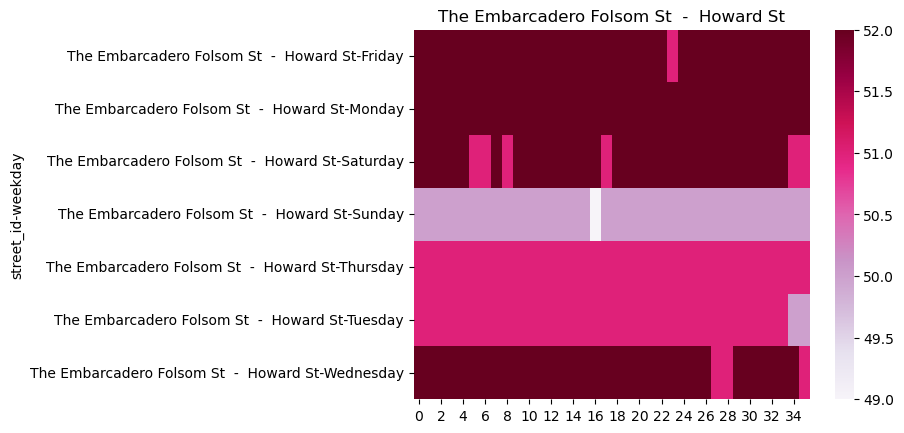

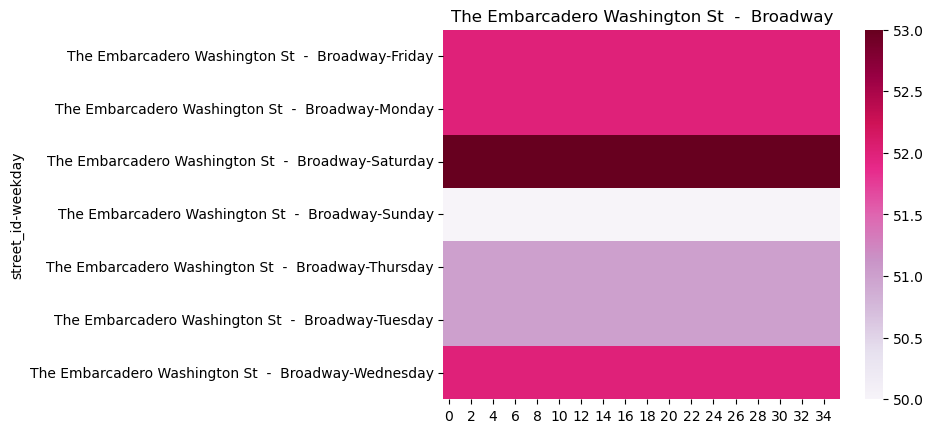

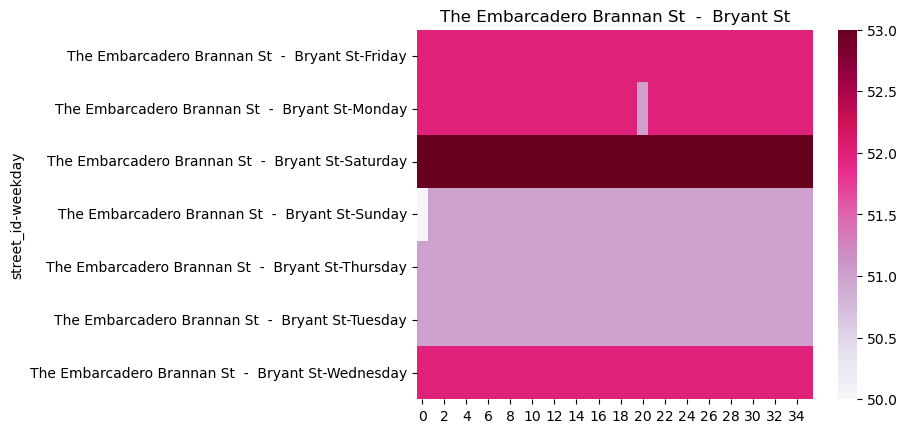

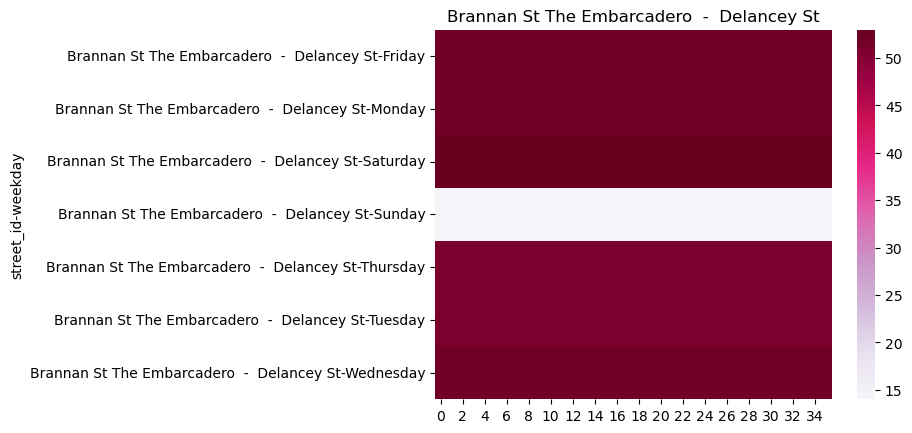

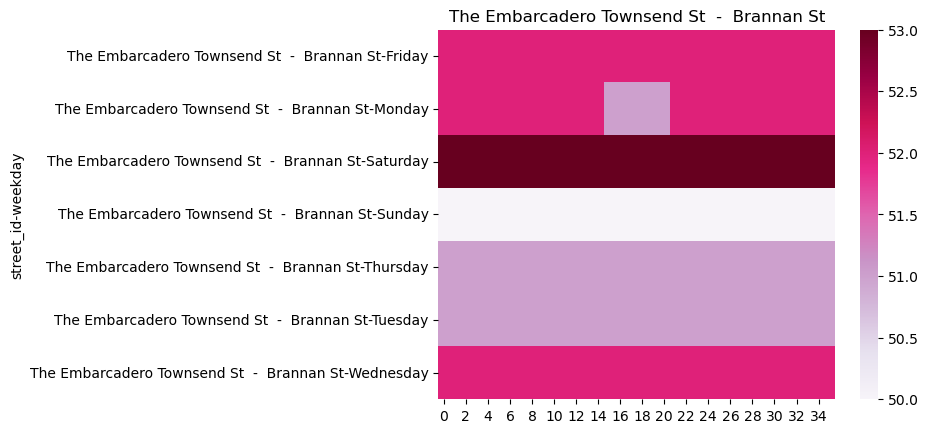

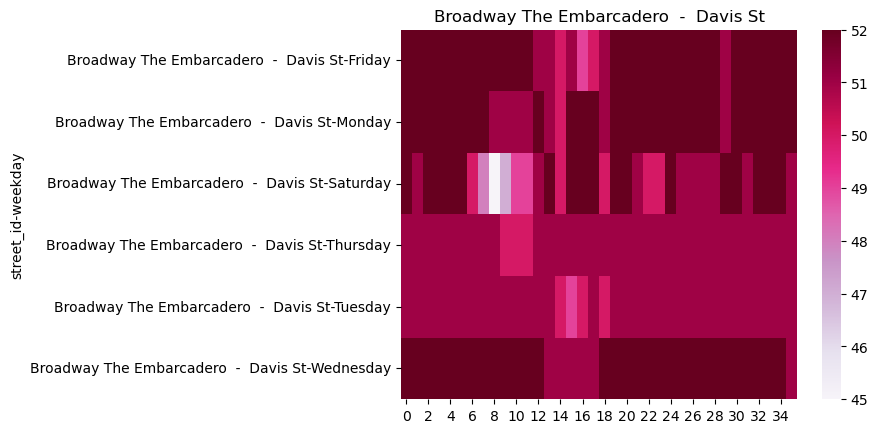

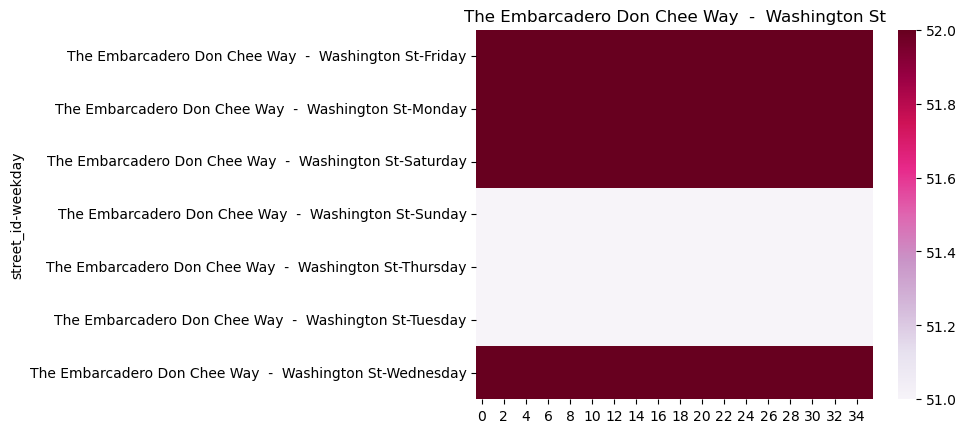

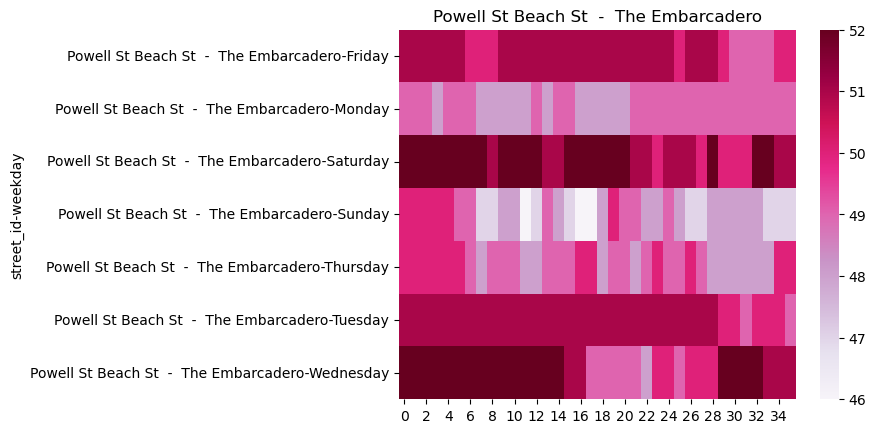

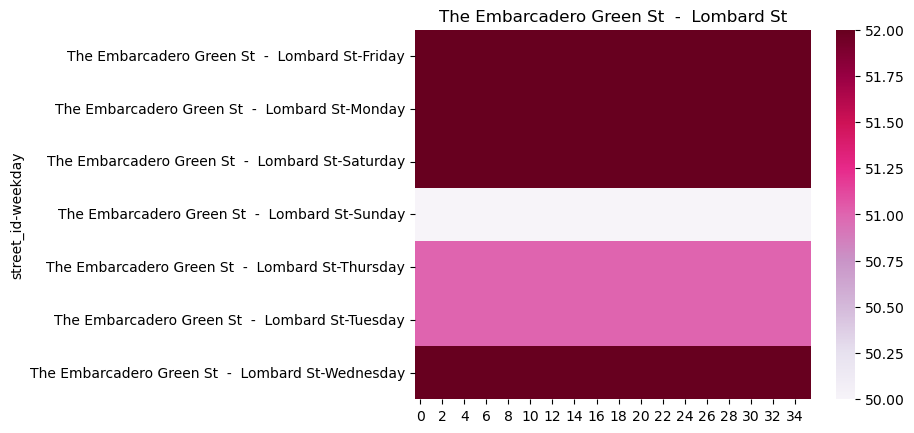

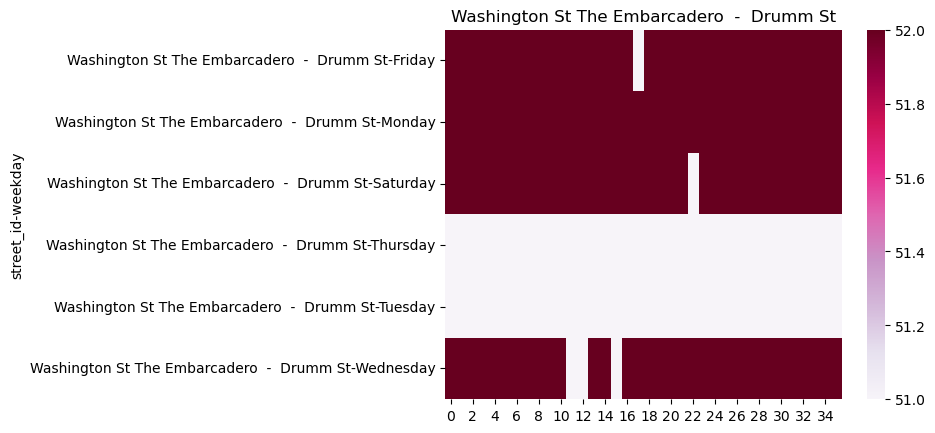

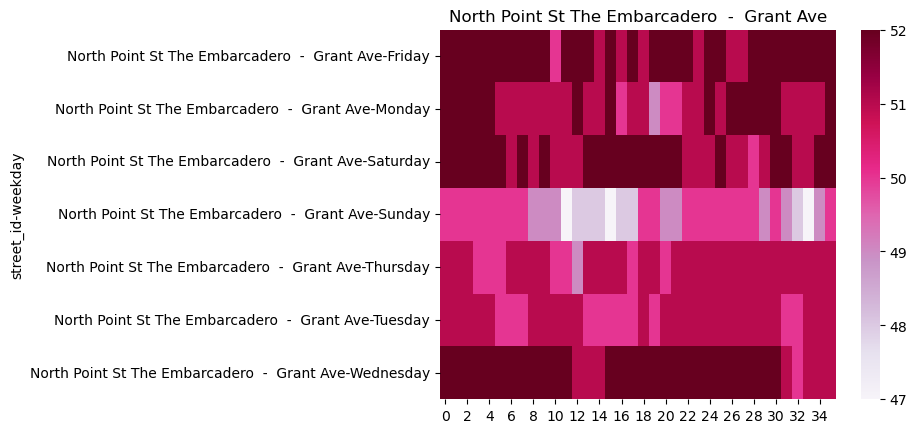

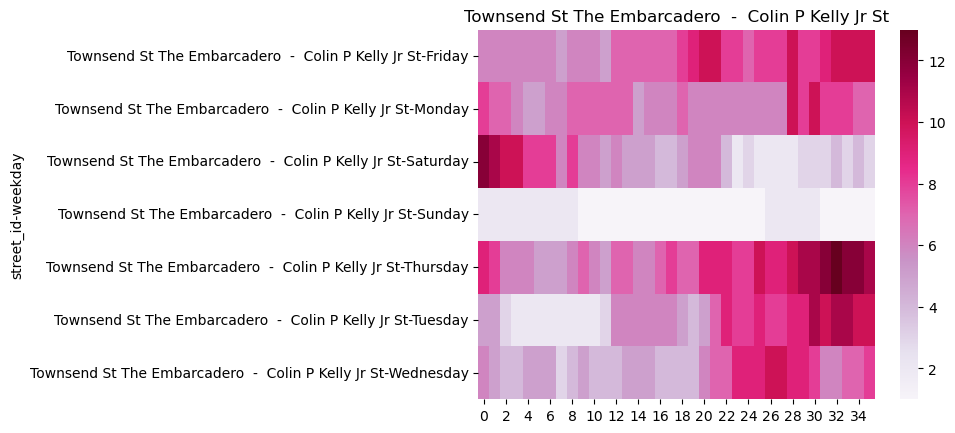

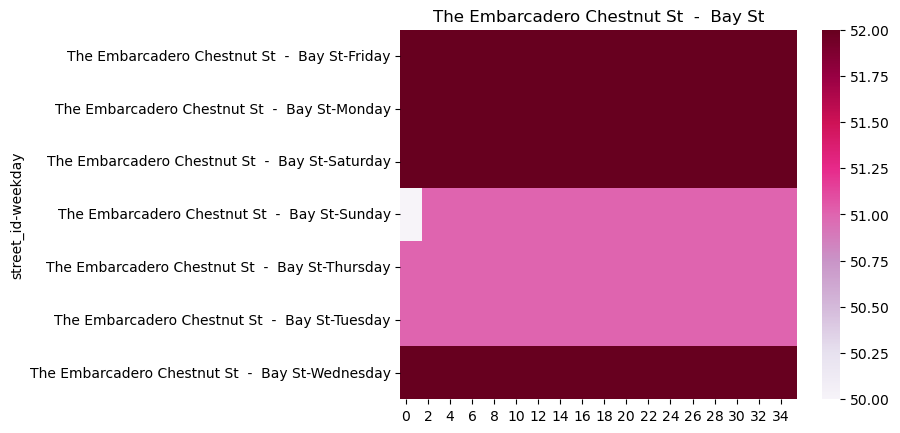

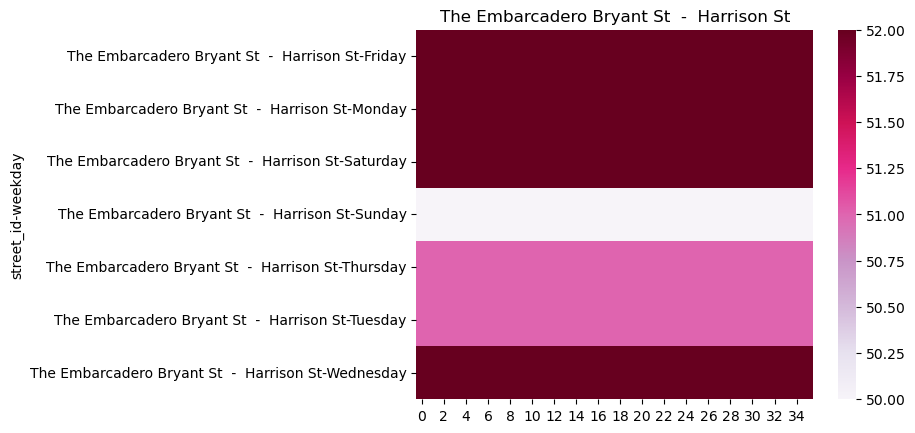

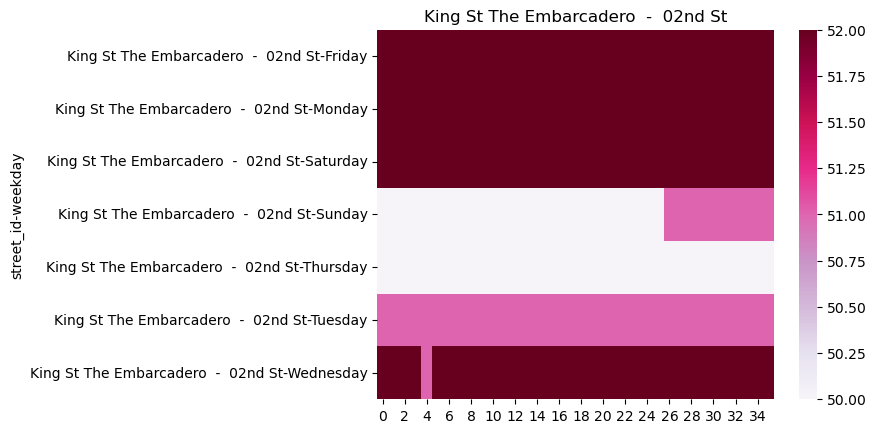

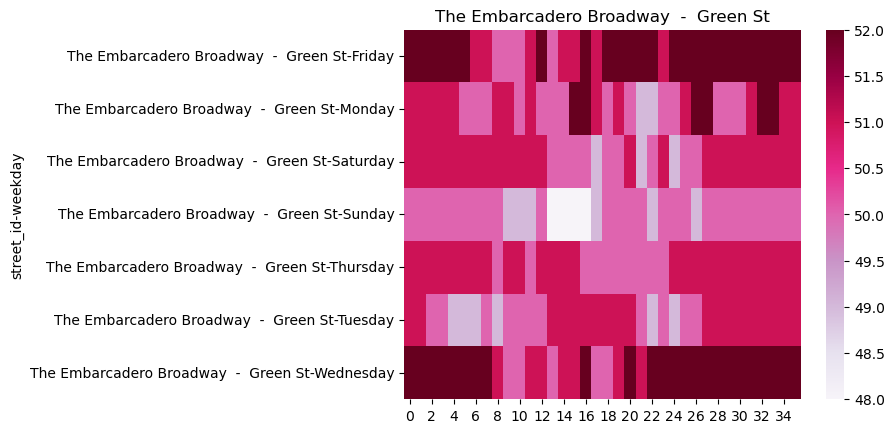

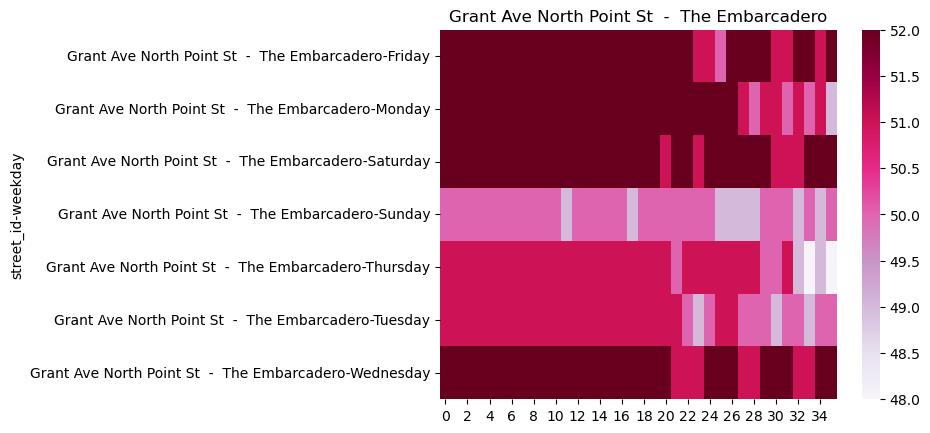

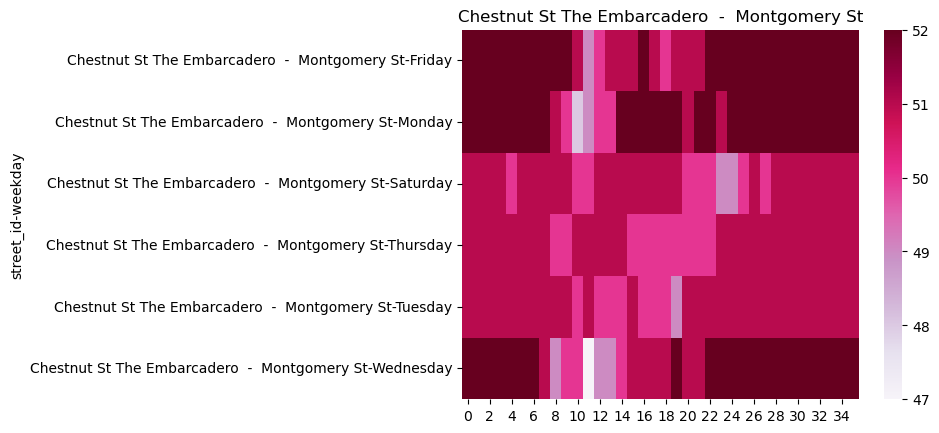

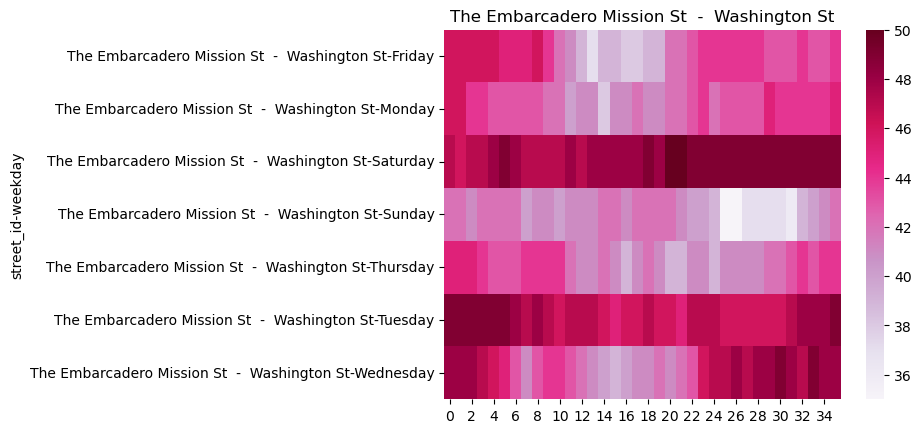

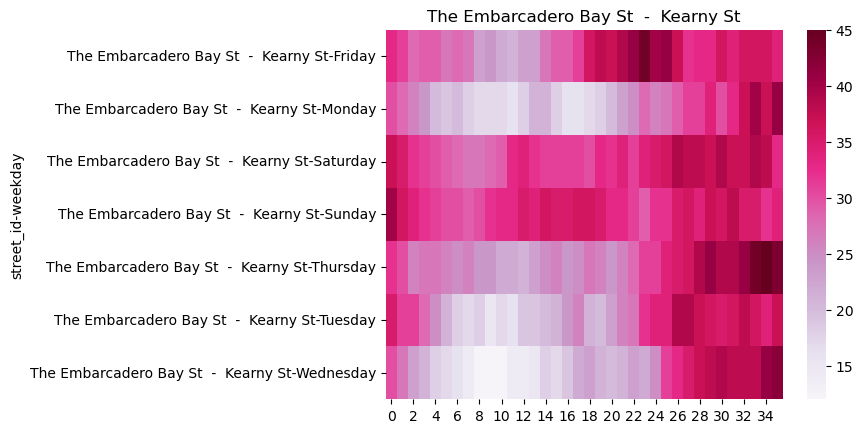

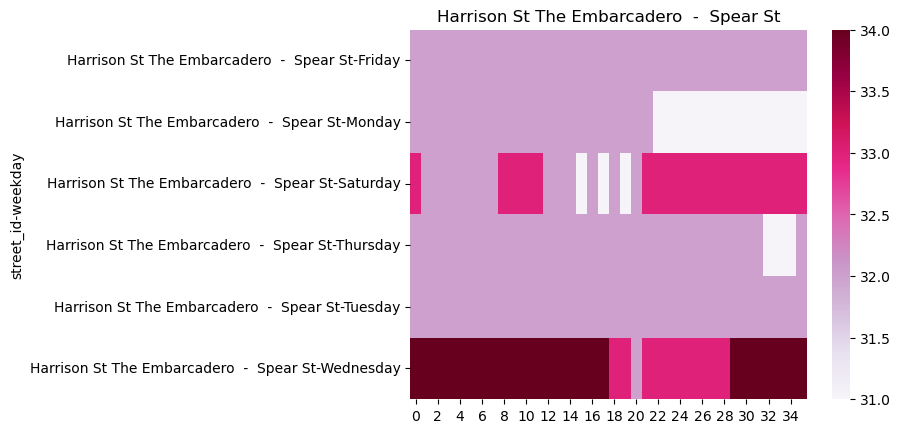

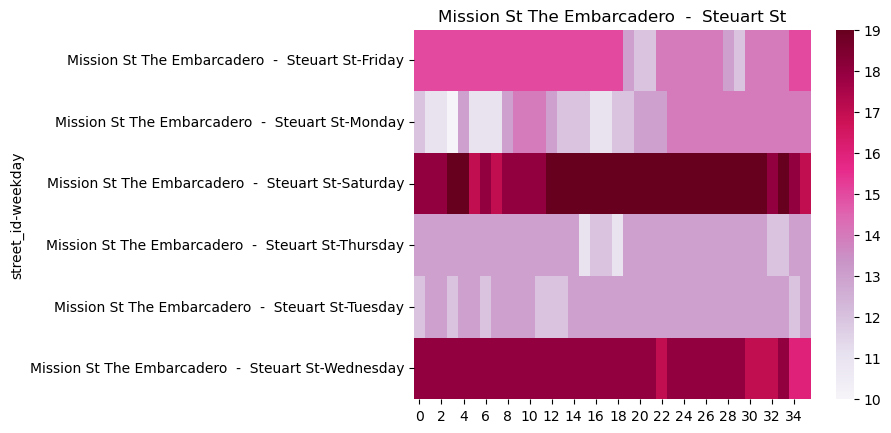

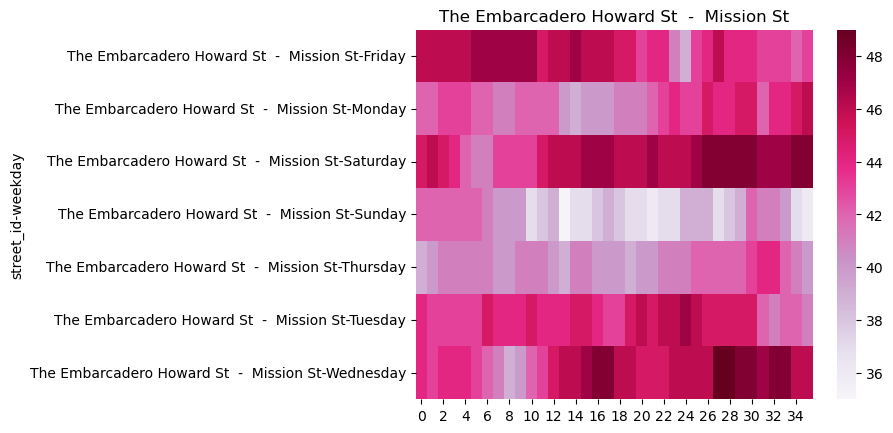

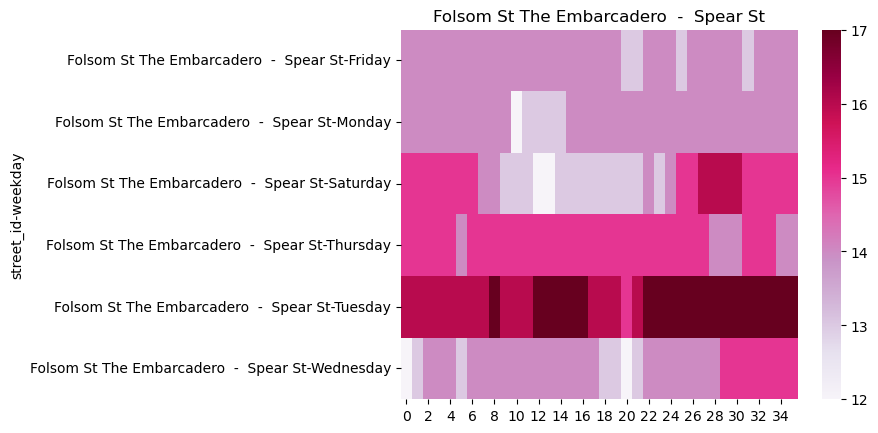

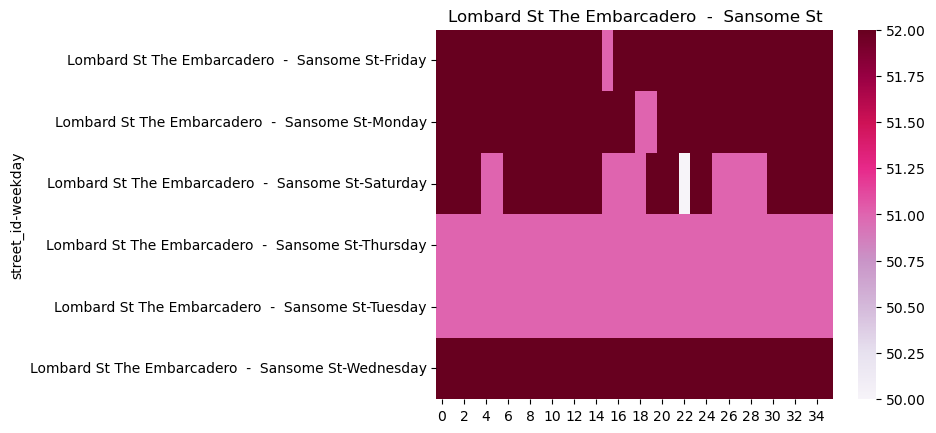

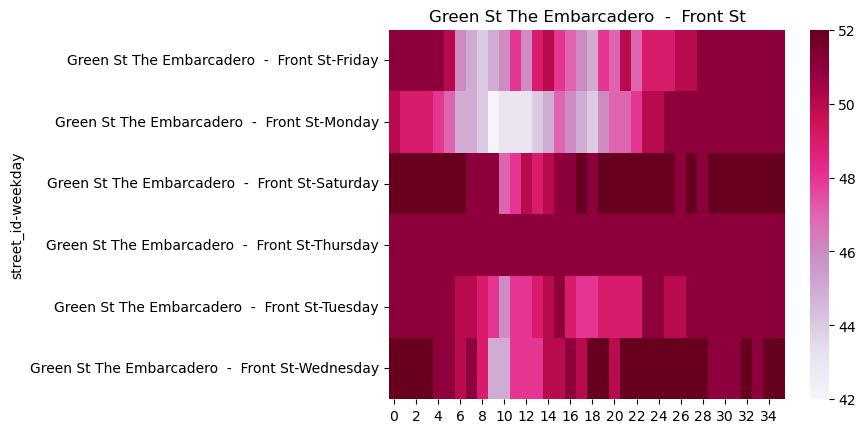

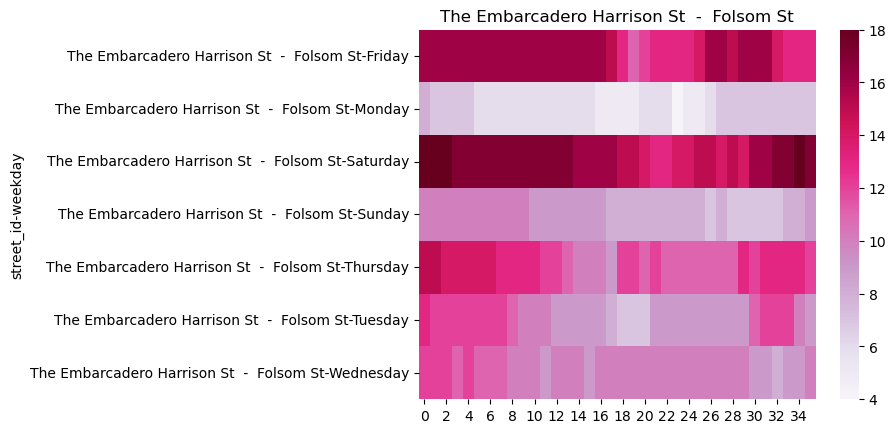

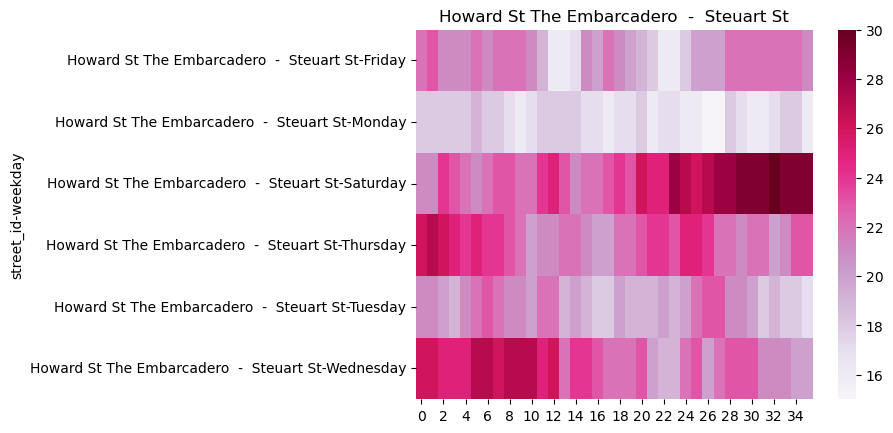

In [108]:
for street_id in df['street_id'].unique():
    slc = final_final_df.iloc[final_final_df.index.get_level_values('street_id') == street_id]
    sns.heatmap(slc, cmap = "PuRd").set(title=street_id)
    plt.show()

In [233]:
# final_final_df.to_csv("../data/final_illegal.csv")

In [178]:
e_and_i = pd.read_csv("../data/prob_e_and_i.csv")
e_and_i

citation_day                         street_id  \
0           Monday    01st St Elim St  -  Mission St   
1          Tuesday    01st St Elim St  -  Mission St   
2        Wednesday    01st St Elim St  -  Mission St   
3         Thursday    01st St Elim St  -  Mission St   
4           Friday    01st St Elim St  -  Mission St   
...            ...                               ...   
14961    Wednesday  Zoe St Freelon St  -  Brannan St   
14962     Thursday  Zoe St Freelon St  -  Brannan St   
14963       Friday  Zoe St Freelon St  -  Brannan St   
14964     Saturday  Zoe St Freelon St  -  Brannan St   
14965       Sunday  Zoe St Freelon St  -  Brannan St   

                                                time_bin  00:00:00  07:00:00  \
0      Counter({'12:00:00': 2, '14:30:00': 2, '00:00:...         0         0   
1      Counter({'11:00:00': 2, '11:45:00': 2, '12:30:...         0         0   
2      Counter({'12:15:00': 3, '12:00:00': 2, '14:15:...         0         0   
3      Counter({'12:15:00': 4, '11:00:00': 2, '11:15:...         0         0   
4      Counter({'12:00:00': 3, '11:30:00': 2, '11:45:...         0         0   
...                                                  ...       ...       ...   
14961  Counter({'12:00:00': 2, '12:45:00': 2, '13:15:...         0         0   
14962  Counter({'12:15:00': 2, '13:15:00': 2, '13:45:...         0         0   
14963  Counter({'12:30:00': 2, '17:45:00': 2, '00:00:...         0         0   
14964  Counter({'14:00:00': 2, '00:00:00': 1, '07:00:...         0         0   
14965  Counter({'00:00:00': 1, '07:00:00': 1, '07:15:...         0         0   

       07:15:00  07:30:00  07:45:00  08:00:00  08:15:00  08:30:00  08:45:00  \
0             0         0         0         0         0         0         0   
1             0         0         0         0         0         0         0   
2             0         0         0         0         0         0         0   
3             0         0         0         0         0         0         0   
4             0         0         0         0         0         0         0   
...         ...       ...       ...       ...       ...       ...       ...   
14961         0         0         0         0         0         0         0   
14962         0         0         0         0         0         0         0   
14963         0         0         0         0         0         0         0   
14964         0         0         0         0         0         0         0   
14965         0         0         0         0         0         0         0   

       09:00:00  09:15:00  09:30:00  09:45:00  10:00:00  10:15:00  10:30:00  \
0             0         0         0         0         0         0         0   
1             0         0         0         0         0         0         0   
2             0         0         0         0         0         0         0   
3             0         0         0         0         0         0         0   
4             0         0         0         0         0         0         0   
...         ...       ...       ...       ...       ...       ...       ...   
14961         0         0         0         0         0         0         0   
14962         0         0         0         0         0         0         0   
14963         0         0         0         0         0         0         0   
14964         0         0         0         0         0         0         0   
14965         0         0         0         0         0         0         0   

       10:45:00  11:00:00  11:15:00  11:30:00  11:45:00  12:00:00  12:15:00  \
0             0         0         0         0         0         1         0   
1             0         1         0         0         1         0         0   
2             0         0         0         0         0         1         2   
3             0         1         1         0         0         0         3   
4             0         0         0         1         1         2         0   


In [179]:
def flatten(l):
    return [item for sublist in l for item in sublist]

streets = flatten([[name]*7 for name in joined["street_id"].unique()])

In [180]:
arrays = [streets, ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]*len(joined["street_id"].unique())]

tuples = list(zip(*arrays))
new_idx = pd.MultiIndex.from_tuples(tuples, names=["streets", "days"])

In [181]:
e_and_i = e_and_i.rename(columns={"street_id": "streets", "citation_day": "days"}).set_index(['streets', 'days']).drop(['time_bin'], axis=1)

In [182]:
final_final_df = final_final_df.reindex(new_idx, fill_value=0)
e_and_i = e_and_i.reindex(new_idx, fill_value=0)

In [183]:
# TODO: we should write actual code to subset the correct time range, instead of using indicies 

e_and_i = e_and_i.iloc[:, 9:45]

In [184]:
e_and_i

09:00:00  09:15:00  \
streets                                  days                            
Mission St 07th St  -  Julia St          Monday            1         1   
                                         Tuesday           1         1   
                                         Wednesday         0         1   
                                         Thursday          2         1   
                                         Friday            2         0   
...                                                      ...       ...   
Sansome St Merchant St  -  Washington St Wednesday         0         0   
                                         Thursday          0         0   
                                         Friday            0         0   
                                         Saturday          0         0   
                                         Sunday            0         0   

                                                    09:30:00  09:45:00  \
streets                                  days                            
Mission St 07th St  -  Julia St          Monday            0         0   
                                         Tuesday           0         0   
                                         Wednesday         0         0   
                                         Thursday          2         0   
                                         Friday            0         0   
...                                                      ...       ...   
Sansome St Merchant St  -  Washington St Wednesday         0         0   
                                         Thursday          0         0   
                                         Friday            0         0   
                                         Saturday          0         0   
                                         Sunday            0         0   

                                                    10:00:00  10:15:00  \
streets                                  days                            
Mission St 07th St  -  Julia St          Monday            0         0   
                                         Tuesday           0         0   
                                         Wednesday         1         0   
                                         Thursday          0         0   
                                         Friday            0         0   
...                                                      ...       ...   
Sansome St Merchant St  -  Washington St Wednesday         0         0   
                                         Thursday          0         0   
                                         Friday            0         0   
                                         Saturday          0         0   
                                         Sunday            0         0   

                                                    10:30:00  10:45:00  \
streets                                  days                            
Mission St 07th St  -  Julia St          Monday            0         0   
                                         Tuesday           0         0   
                                         Wednesday         1         0   
                                         Thursday          0         1   
                                         Friday            0         0   
...                                                      ...       ...   
Sansome St Merchant St  -  Washington St Wednesday         0         0   
                                         Thursday          0         0   
                                         Friday            0         0   
                                         Saturday          0         0   
                                         Sunday            0         0   

                                                    11:00:00  11:15:00  \
streets                                  days                            
Mission St 07th St  -  Julia St          Monday     

In [185]:
in_given_il = e_and_i.divide(final_final_df.values).fillna(0)
#(in_given_il.isnull()).sum().sum()
in_given_il

09:00:00  09:15:00  \
streets                                  days                            
Mission St 07th St  -  Julia St          Monday          inf       inf   
                                         Tuesday         inf       inf   
                                         Wednesday       0.0       inf   
                                         Thursday        inf       inf   
                                         Friday          inf       0.0   
...                                                      ...       ...   
Sansome St Merchant St  -  Washington St Wednesday       0.0       0.0   
                                         Thursday        0.0       0.0   
                                         Friday          0.0       0.0   
                                         Saturday        0.0       0.0   
                                         Sunday          0.0       0.0   

                                                    09:30:00  09:45:00  \
streets                                  days                            
Mission St 07th St  -  Julia St          Monday          0.0       0.0   
                                         Tuesday         0.0       0.0   
                                         Wednesday       0.0       0.0   
                                         Thursday        inf       0.0   
                                         Friday          0.0       0.0   
...                                                      ...       ...   
Sansome St Merchant St  -  Washington St Wednesday       0.0       0.0   
                                         Thursday        0.0       0.0   
                                         Friday          0.0       0.0   
                                         Saturday        0.0       0.0   
                                         Sunday          0.0       0.0   

                                                    10:00:00  10:15:00  \
streets                                  days                            
Mission St 07th St  -  Julia St          Monday          0.0       0.0   
                                         Tuesday         0.0       0.0   
                                         Wednesday       inf       0.0   
                                         Thursday        0.0       0.0   
                                         Friday          0.0       0.0   
...                                                      ...       ...   
Sansome St Merchant St  -  Washington St Wednesday       0.0       0.0   
                                         Thursday        0.0       0.0   
                                         Friday          0.0       0.0   
                                         Saturday        0.0       0.0   
                                         Sunday          0.0       0.0   

                                                    10:30:00  10:45:00  \
streets                                  days                            
Mission St 07th St  -  Julia St          Monday          0.0       0.0   
                                         Tuesday         0.0       0.0   
                                         Wednesday       inf       0.0   
                                         Thursday        0.0       inf   
                                         Friday          0.0       0.0   
...                                                      ...       ...   
Sansome St Merchant St  -  Washington St Wednesday       0.0       0.0   
                                         Thursday        0.0       0.0   
                                         Friday          0.0       0.0   
                                         Saturday        0.0       0.0   
                                         Sunday          0.0       0.0   

                                                    11:00:00  11:15:00  \
streets                                  days                            
Mission St 07th St  -  Julia St          Monday     

In [186]:
in_given_il = in_given_il.reset_index()
in_given_il[in_given_il['streets'].str.contains('Embarcadero')]

streets       days  09:00:00  \
140            The Embarcadero Bryant St  -  Harrison St     Monday  0.019231   
141            The Embarcadero Bryant St  -  Harrison St    Tuesday  0.019608   
142            The Embarcadero Bryant St  -  Harrison St  Wednesday  0.038462   
143            The Embarcadero Bryant St  -  Harrison St   Thursday  0.019608   
144            The Embarcadero Bryant St  -  Harrison St     Friday  0.000000   
...                                                  ...        ...       ...   
14667  Townsend St The Embarcadero  -  Colin P Kelly ...  Wednesday  0.333333   
14668  Townsend St The Embarcadero  -  Colin P Kelly ...   Thursday  0.222222   
14669  Townsend St The Embarcadero  -  Colin P Kelly ...     Friday  0.166667   
14670  Townsend St The Embarcadero  -  Colin P Kelly ...   Saturday  0.000000   
14671  Townsend St The Embarcadero  -  Colin P Kelly ...     Sunday  0.000000   

       09:15:00  09:30:00  09:45:00  10:00:00  10:15:00  10:30:00  10:45:00  \
140    0.000000  0.038462  0.000000  0.000000  0.000000  0.000000  0.019231   
141    0.039216  0.058824  0.058824  0.000000  0.000000  0.019608  0.000000   
142    0.000000  0.038462  0.038462  0.019231  0.000000  0.019231  0.076923   
143    0.019608  0.000000  0.019608  0.039216  0.039216  0.019608  0.078431   
144    0.000000  0.000000  0.000000  0.000000  0.000000  0.038462  0.115385   
...         ...       ...       ...       ...       ...       ...       ...   
14667  0.400000  0.500000  0.250000  0.000000  0.000000  0.800000  0.333333   
14668  0.500000  0.500000  0.166667  0.000000  0.400000  0.600000  0.400000   
14669  0.166667  0.666667  0.000000  0.333333  0.000000  0.333333  0.400000   
14670  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.333333   
14671  0.000000  0.000000  0.000000  0.500000  0.000000  0.500000  0.500000   

       11:00:00  11:15:00  11:30:00  11:45:00  12:00:00  12:15:00  12:30:00  \
140    0.019231  0.057692  0.019231  0.038462  0.038462  0.019231  0.000000   
141    0.078431  0.039216  0.000000  0.019608  0.039216  0.058824  0.019608   
142    0.076923  0.057692  0.038462  0.038462  0.038462  0.096154  0.019231   
143    0.039216  0.000000  0.019608  0.039216  0.039216  0.039216  0.019608   
144    0.038462  0.076923  0.000000  0.019231  0.019231  0.019231  0.019231   
...         ...       ...       ...       ...       ...       ...       ...   
14667  0.250000  0.600000  0.250000  1.250000  1.000000  0.000000  0.200000   
14668  0.500000  0.285714  0.166667  0.200000  0.285714  0.142857  0.000000   
14669  0.666667  0.500000  0.666667  0.400000  0.000000  0.285714  0.428571   
14670  0.125000  0.000000  0.000000  0.000000  0.500000  0.200000  0.600000   
14671  1.000000  1.000000  5.000000  4.000000  1.000000  0.000000  2.000000   

       12:45:00  13:00:00  13:15:00  13:30:00  13:45:00  14:00:00  14:15:00  \
140    0.000000  0.019231  0.019231  0.000000  0.019231  0.000000  0.000000   
141    0.000000  0.019608  0.058824  0.078431  0.039216  0.039216  0.000000   
142    0.000000  0.019231  0.019231  0.038462  0.057692  0.057692  0.000000   
143    0.000000  0.039216  0.000000  0.019608  0.058824  0.078431  0.039216   
144    0.019231  0.038462  0.000000  0.019231  0.076923  0.038462  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
14667  0.000000  0.250000  0.750000  0.500000  0.250000  0.000000  0.142857   
14668  0.166667  0.000000  0.250000  0.428571  0.571429  0.000000  0.111111   
14669  0.142857  0.142857  0.000000  0.125000  0.111111  0.200000  0.100000   
14670  0.000000  0.500000  0.250000  0.000000  0.000000  0.166667  0.166667   
14671  0.000000  2.000000  0.000000  0.000000  2.000000  0.000000  0.000000   

       14:30:00  14:45:00  15:00:00  15:15:00  15:30:00  15:45:00  16:00:00  \
140    0.038462  0.000000  0.057692  0.038462  0.000000  0.019231  0.019231   
141    0.000000  0.000000  0.117647  0.019608  0.000000  0.000000  0.01

In [187]:
g = e_and_i.reset_index()
g[(g['streets'] == in_given_il.iloc[14671]['streets']) & (g['days'] == in_given_il.iloc[14671]['days'])]

streets    days  09:00:00  \
14671  Townsend St The Embarcadero  -  Colin P Kelly ...  Sunday         0   

       09:15:00  09:30:00  09:45:00  10:00:00  10:15:00  10:30:00  10:45:00  \
14671         0         0         0         1         0         1         1   

       11:00:00  11:15:00  11:30:00  11:45:00  12:00:00  12:15:00  12:30:00  \
14671         2         1         5         4         1         0         2   

       12:45:00  13:00:00  13:15:00  13:30:00  13:45:00  14:00:00  14:15:00  \
14671         0         2         0         0         2         0         0   

       14:30:00  14:45:00  15:00:00  15:15:00  15:30:00  15:45:00  16:00:00  \
14671         1         1         2         2         5         3         5   

       16:15:00  16:30:00  16:45:00  17:00:00  17:15:00  17:30:00  17:45:00  
14671         4         1         0         0         0         0         1

In [188]:
x = final_final_df.reset_index()
x[(x['streets'] == in_given_il.iloc[14671]['streets']) & (x['days'] == in_given_il.iloc[14671]['days'])]

streets    days  0  1  2  3  \
14671  Townsend St The Embarcadero  -  Colin P Kelly ...  Sunday  2  2  2  2   

       4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  \
14671  2  2  2  2  2  1   1   1   1   1   1   1   1   1   1   1   1   1   1   

       23  24  25  26  27  28  29  30  31  32  33  34  35  
14671   1   1   1   2   2   2   2   2   1   1   1   1   1

In [189]:
embarcadero[(embarcadero[[col for col in embarcadero.columns if col not in ['streets', 'days']]] > 1).any(axis=1)]

streets       days  09:00:00  \
3443       Chestnut St The Embarcadero  -  Montgomery St     Sunday       0.0   
4696            Harrison St The Embarcadero  -  Spear St     Sunday       0.0   
14666  Townsend St The Embarcadero  -  Colin P Kelly ...    Tuesday       0.0   
14667  Townsend St The Embarcadero  -  Colin P Kelly ...  Wednesday       0.5   
14671  Townsend St The Embarcadero  -  Colin P Kelly ...     Sunday       0.0   

       09:15:00  09:30:00  09:45:00  10:00:00  10:15:00  10:30:00  10:45:00  \
3443        0.0  0.000000      0.00       0.0       0.0       0.0       inf   
4696        0.0  0.000000      0.00       0.0       0.0       0.0  0.000000   
14666       0.4  0.333333      1.50       1.0       0.5       0.5  1.500000   
14667       0.4  0.500000      0.25       0.2       0.0       0.8  0.333333   
14671       0.0  0.000000      0.00       0.5       0.0       0.5  0.500000   

       11:00:00  11:15:00  11:30:00  11:45:00  12:00:00  12:15:00  12:30:00  \
3443       0.00       0.0      0.00  0.000000  0.000000  0.000000       0.0   
4696       0.00       0.0      0.00  0.000000       inf  0.000000       0.0   
14666      1.00       0.5      1.00  0.333333  0.166667  0.333333       0.5   
14667      0.25       0.6      0.25  1.250000  1.000000  0.000000       0.4   
14671      1.00       1.0      5.00  5.000000  1.000000  0.000000       3.0   

       12:45:00  13:00:00  13:15:00  13:30:00  13:45:00  14:00:00  14:15:00  \
3443        0.0      0.00      0.00       0.0      0.00       0.0  0.000000   
4696        inf       inf      0.00       0.0      0.00       0.0  0.000000   
14666       0.0      0.00      0.00       0.2      0.25       0.2  0.142857   
14667       0.0      0.25      0.75       0.5      0.25       0.0  0.142857   
14671       0.0      2.00      0.00       0.0      2.00       0.0  0.000000   

       14:30:00  14:45:00  15:00:00  15:15:00  15:30:00  15:45:00  16:00:00  \
3443   0.000000  0.000000  0.000000       0.0       0.0       0.0       inf   
4696   0.000000  0.000000  0.000000       0.0       0.0       0.0       inf   
14666  0.111111  0.000000  0.125000       0.0       0.0       0.0  0.222222   
14667  0.000000  0.222222  0.111111       0.0       0.0       0.0  0.111111   
14671  2.000000  2.000000  2.000000       2.0       2.5       1.5  3.000000   

       16:15:00  16:30:00  16:45:00  17:00:00  17:15:00  17:30:00  17:45:00  
3443        inf     0.000       0.0  0.000000  0.000000       0.0       0.0  
4696        0.0     0.000       0.0  0.000000  0.000000       0.0       0.0  
14666       0.0     0.000       0.0  0.000000  0.000000       0.0       0.0  
14667       0.0     0.125       0.0  0.166667  0.142857       0.0       0.0  
14671       2.0     0.500       0.0  0.000000  0.000000       0.0       1.0

In [228]:
embarcadero = in_given_il[in_given_il['streets'].str.contains('Embarcadero')]
(embarcadero[[col for col in embarcadero.columns if col not in ['streets', 'days']]] > 1).any(axis=1).sum()

4

In [229]:
# useful thing

# embarcadero[(embarcadero[[col for col in embarcadero.columns if col not in ['streets', 'days']]] > 1).any(axis=1)]

In [212]:
# also useful
# g is for e_and_i
# x is for i 

# g[(g['streets'] == 'Chestnut St The Embarcadero  -  Montgomery St') & (g['days'] == 'Sunday')]
# x[(x['streets'] == 'Chestnut St The Embarcadero  -  Montgomery St') & (x['days'] == 'Sunday')]

streets    days  09:00:00  \
3443  Chestnut St The Embarcadero  -  Montgomery St  Sunday         0   

      09:15:00  09:30:00  09:45:00  10:00:00  10:15:00  10:30:00  10:45:00  \
3443         0         0         0         0         0         0         1   

      11:00:00  11:15:00  11:30:00  11:45:00  12:00:00  12:15:00  12:30:00  \
3443         0         0         0         0         0         0         0   

      12:45:00  13:00:00  13:15:00  13:30:00  13:45:00  14:00:00  14:15:00  \
3443         0         0         0         0         0         0         0   

      14:30:00  14:45:00  15:00:00  15:15:00  15:30:00  15:45:00  16:00:00  \
3443         0         0         0         0         0         0         1   

      16:15:00  16:30:00  16:45:00  17:00:00  17:15:00  17:30:00  17:45:00  
3443         1         0         0         0         0         0         0

In [230]:
embarcadero.replace([np.inf], 0, inplace=True)

/var/folders/lr/597pxhmx2z78r4vysc_dvsth0000gn/T/ipykernel_70083/1580987208.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [221]:
# sanity check to see that there are no infs in the dataframe.

# np.isinf(embarcadero[[col for col in embarcadero if col not in ['streets', 'days']]]).sum().sum()

In [232]:
embarcadero = embarcadero.set_index('days')

In [238]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [ ]:
from datetime import date, timedelta

df.sort_values("Citation Issued DateTime").head()
sdate = date(2022,1,1)   # start date
edate = date(2023,2,20)   # end date
dates = pd.date_range(sdate, edate-timedelta(days=1),freq='d')
dates_counts = dates.day_name().value_counts().reindex(weekdays)

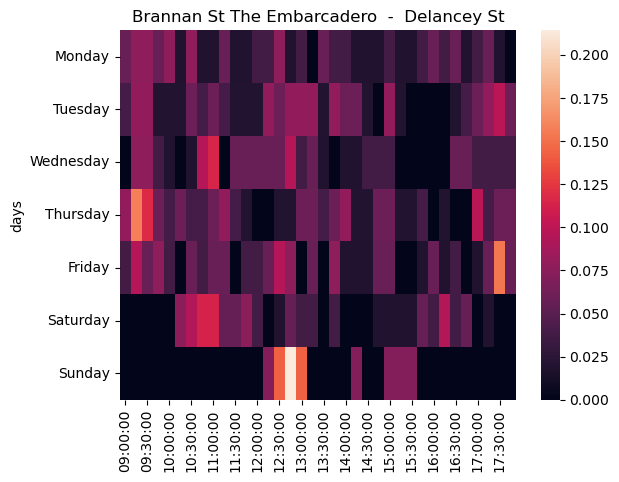

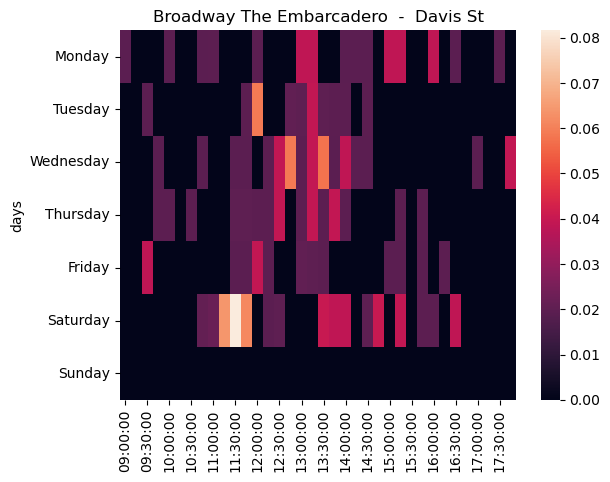

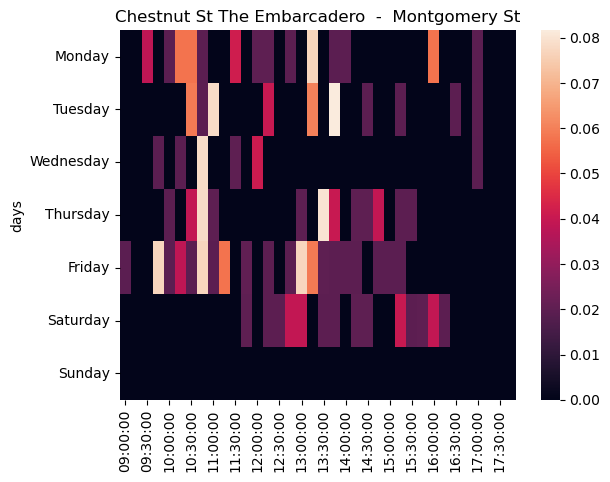

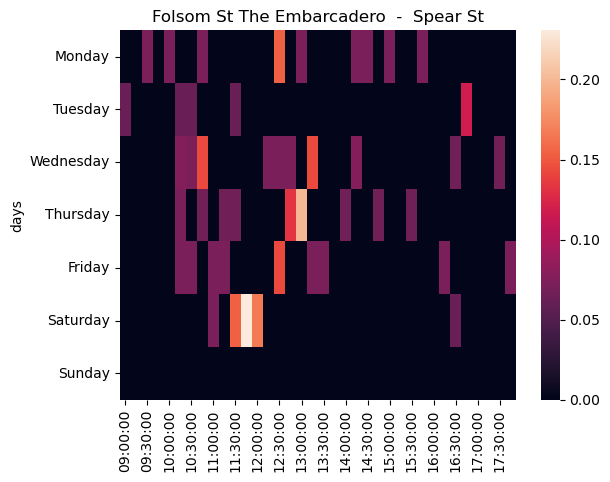

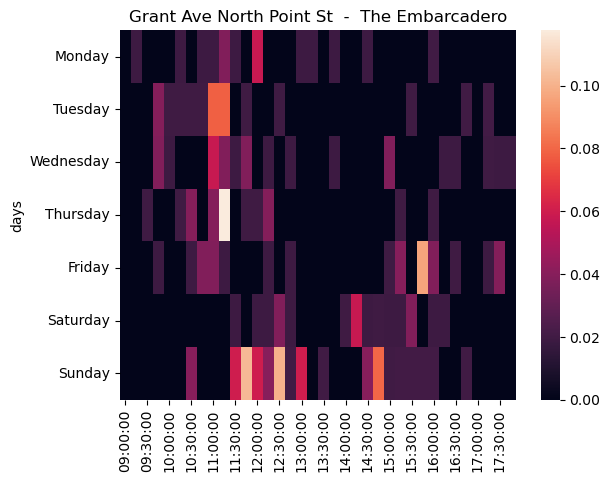

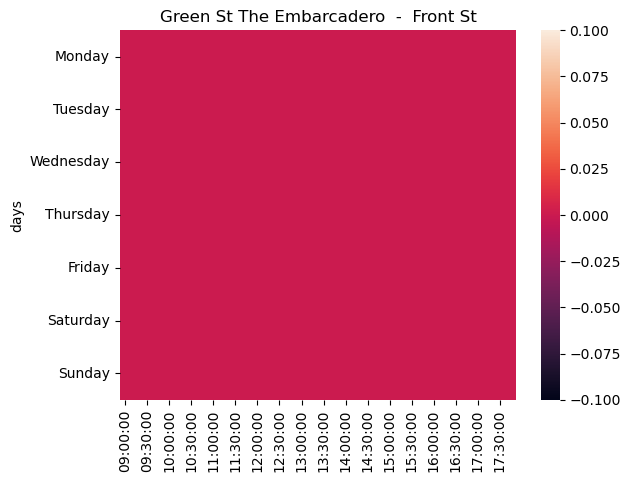

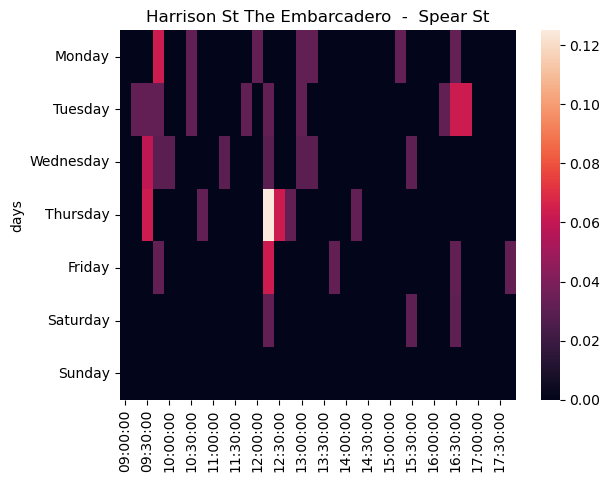

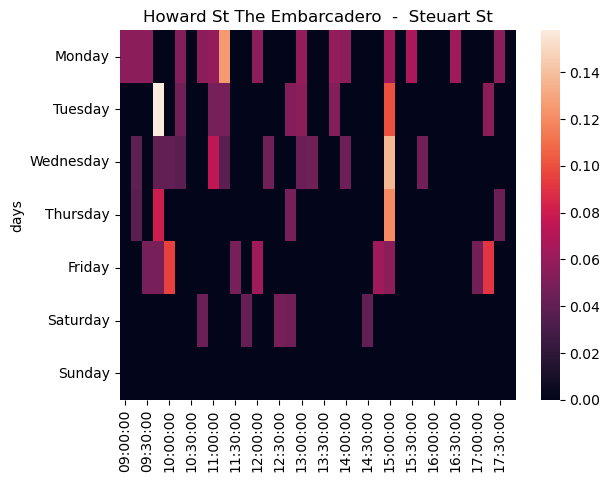

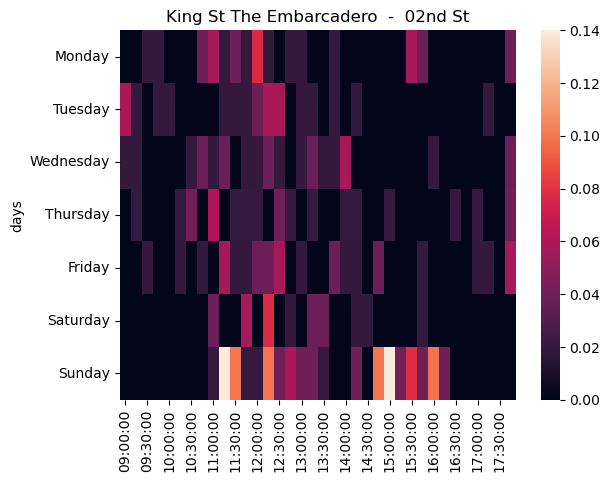

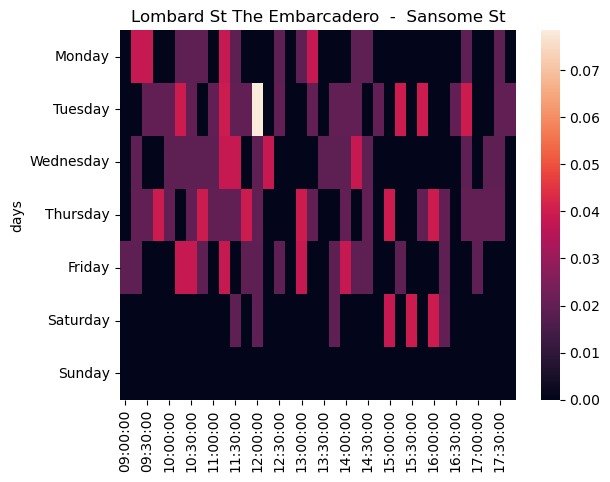

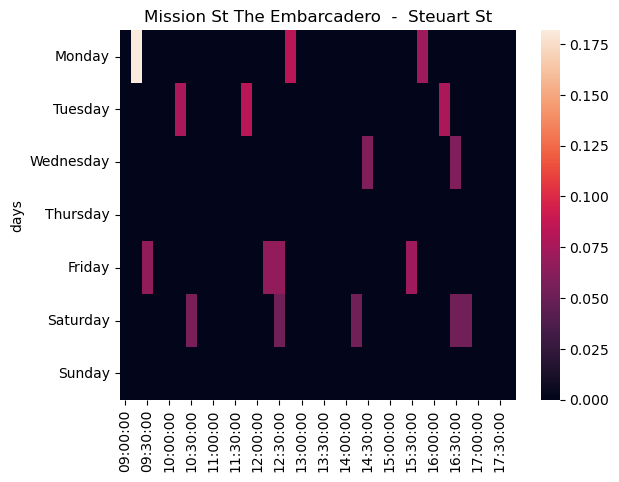

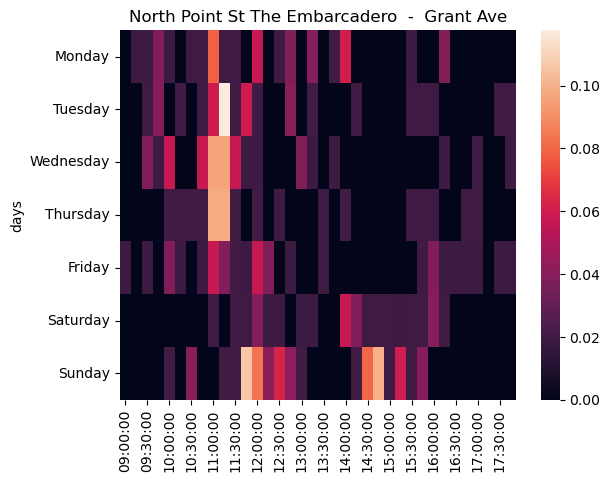

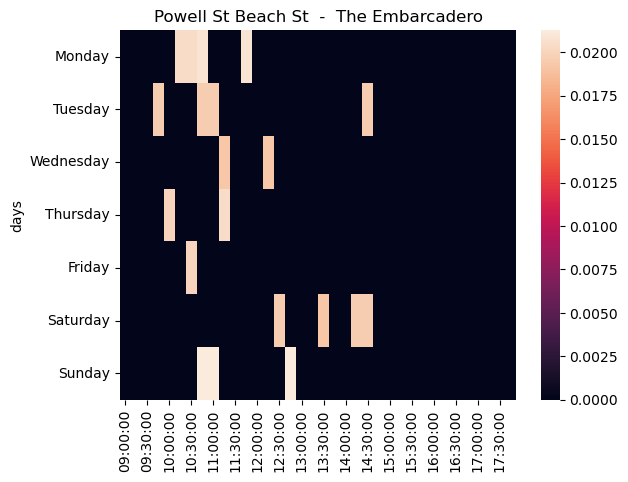

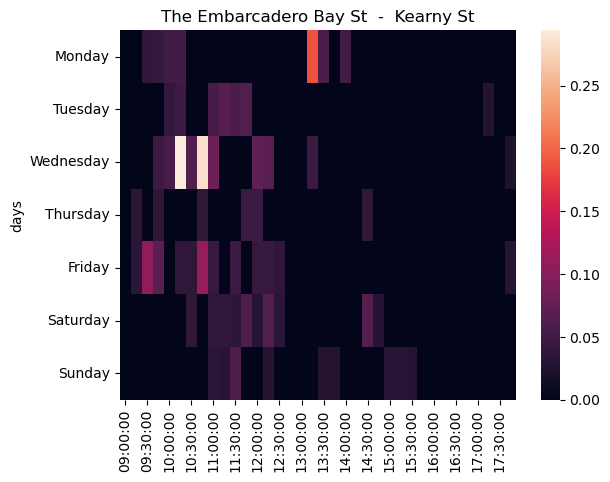

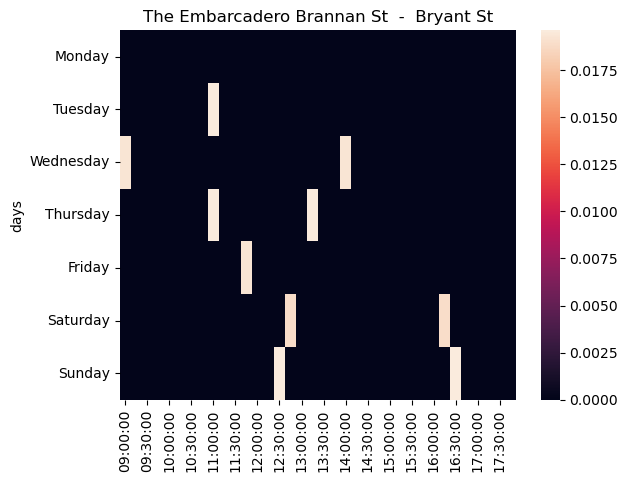

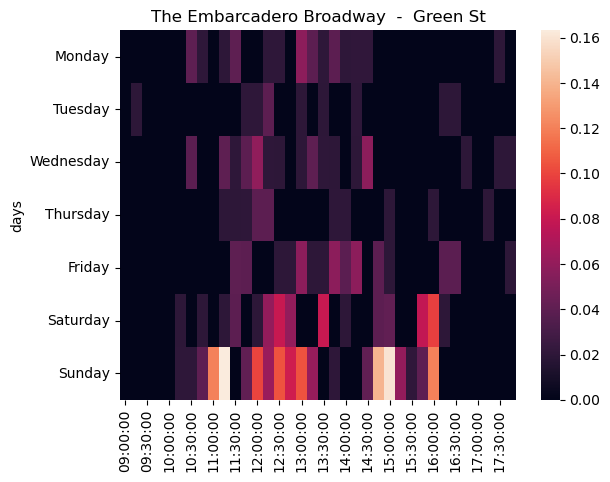

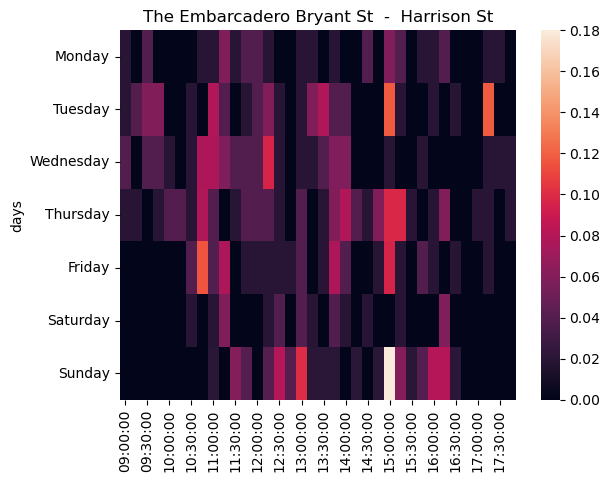

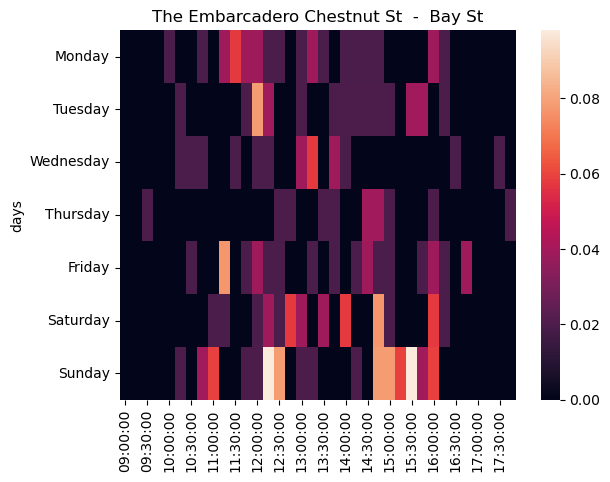

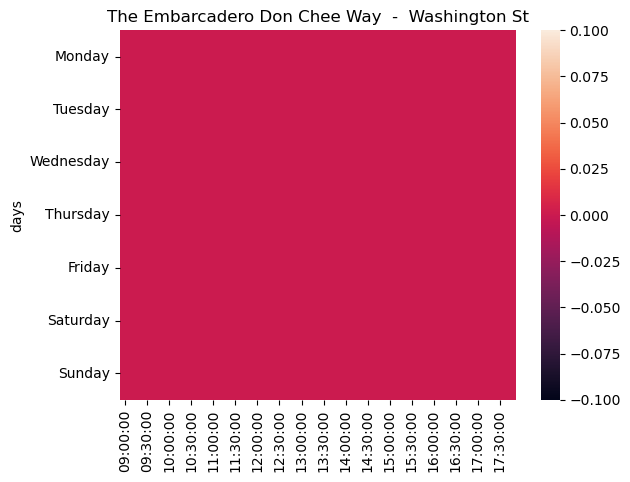

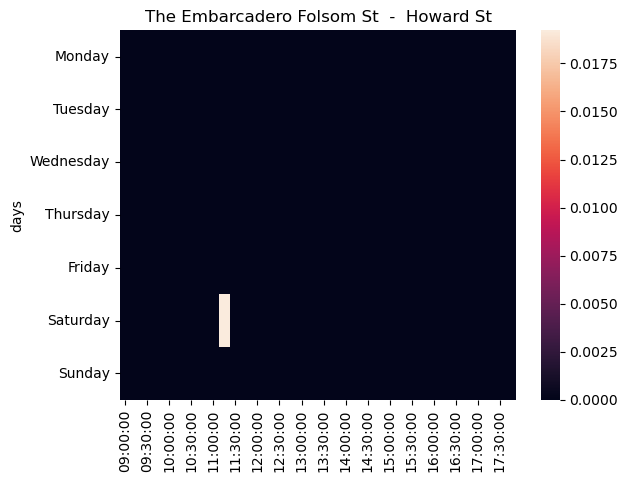

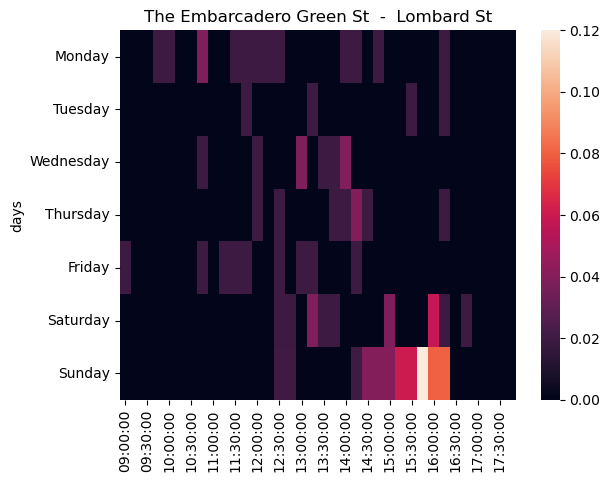

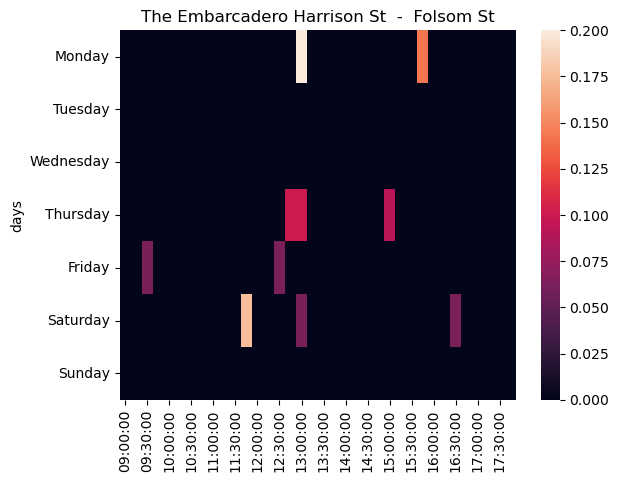

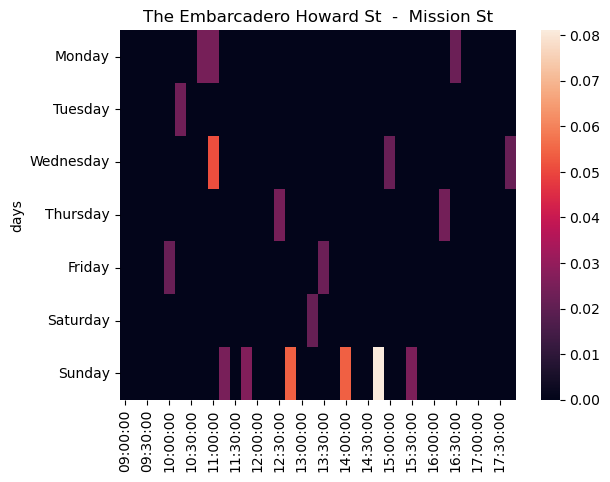

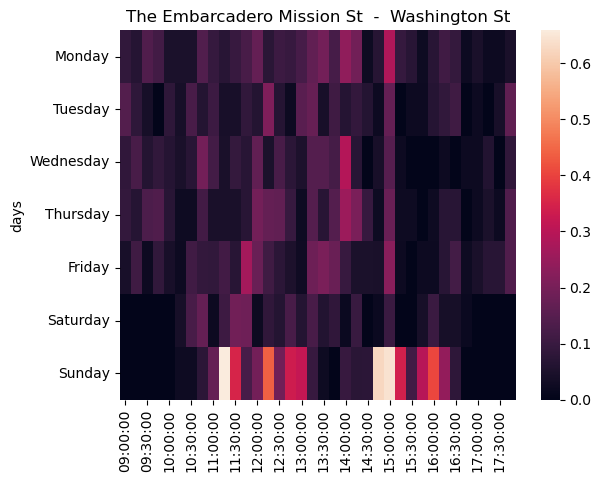

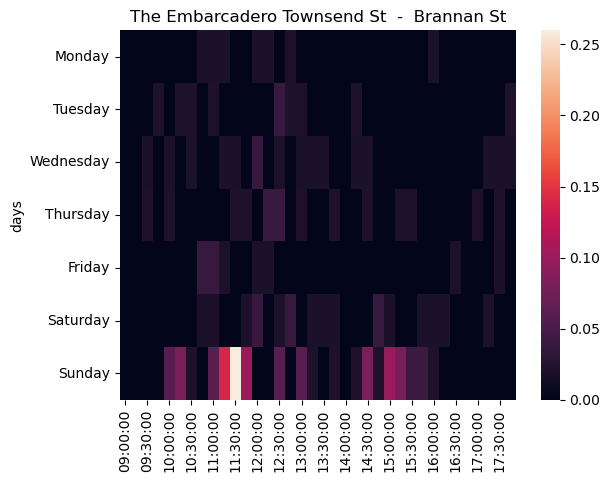

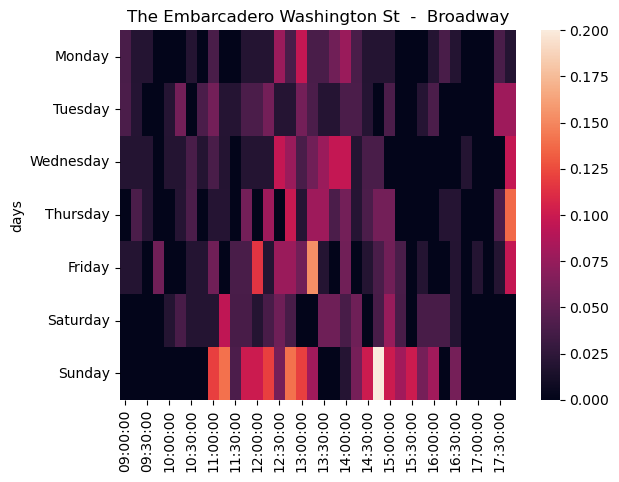

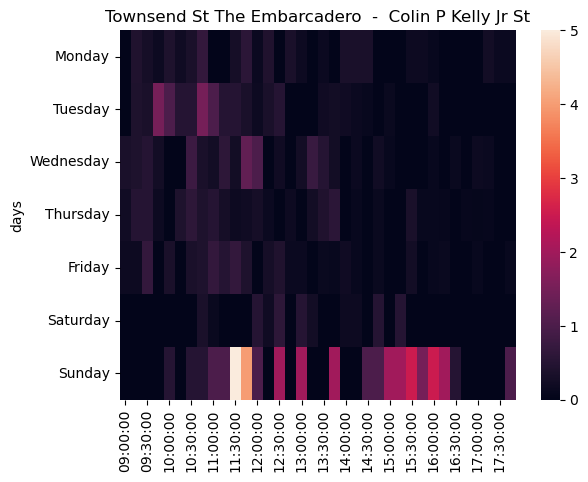

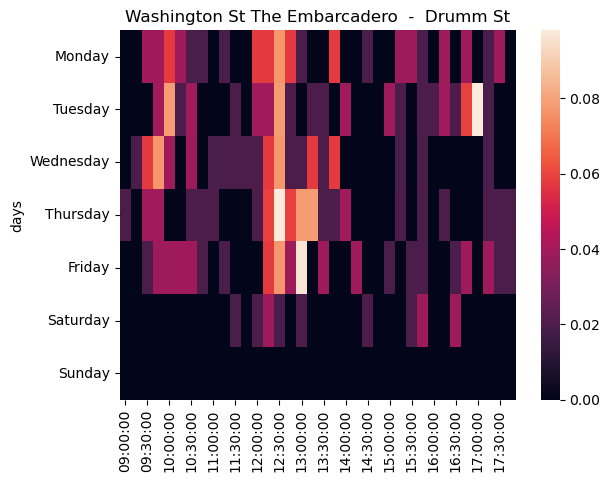

In [239]:
for street_id in sorted(embarcadero.streets.unique()):
    sns.heatmap(embarcadero[embarcadero.streets == street_id].drop(['streets'], axis=1)).set(title=street_id)
    plt.show()

In [193]:
in_given_il[in_given_il != 0]

09:00:00  09:15:00  09:30:00  \
streets                            days                                      
Mission St 07th St  -  Julia St    Monday            0         0         0   
                                   Tuesday           0         0         0   
                                   Wednesday         0         0         0   
                                   Thursday          0         0         0   
                                   Friday            0         0         0   
...                                                ...       ...       ...   
Webster St Union St  -  Filbert St Wednesday         0         0         0   
                                   Thursday          0         0         0   
                                   Friday            0         0         0   
                                   Saturday          0         0         0   
                                   Sunday            0         0         0   

                                              09:45:00  10:00:00  10:15:00  \
streets                            days                                      
Mission St 07th St  -  Julia St    Monday            0         0         0   
                                   Tuesday           0         0         0   
                                   Wednesday         0         0         0   
                                   Thursday          0         0         0   
                                   Friday            0         0         0   
...                                                ...       ...       ...   
Webster St Union St  -  Filbert St Wednesday         0         0         0   
                                   Thursday          0         0         0   
                                   Friday            0         0         0   
                                   Saturday          0         0         0   
                                   Sunday            0         0         0   

                                              10:30:00  10:45:00  11:00:00  \
streets                            days                                      
Mission St 07th St  -  Julia St    Monday            0         0         0   
                                   Tuesday           0         0         0   
                                   Wednesday         0         0         0   
                                   Thursday          0         0         0   
                                   Friday            0         0         0   
...                                                ...       ...       ...   
Webster St Union St  -  Filbert St Wednesday         0         0         0   
                                   Thursday          0         0         0   
                                   Friday            0         0         0   
                                   Saturday          0         0         0   
                                   Sunday            0         0         0   

                                              11:15:00  ...  15:30:00  \
streets                            days                 ...             
Mission St 07th St  -  Julia St    Monday            0  ...         0   
                                   Tuesday           0  ...         0   
                                   Wednesday         0  ...         0   
                                   Thursday          0  ...         0   
                                   Friday            0  ...         0   
...                                                ...  ...       ...   
Webster St Union St  -  Filbert St Wednesday         0  ...         0   
                                   Thursday          0  ...         0   
                                   Friday            0  ...         0   
                                   Saturday          0  ...         0   
                                   Sunday            0  ...         0   

                                              15:45